In [1]:
import pandas as pd

# Load datasets
harris_df = pd.read_csv("./harris_updated_debate.csv")
trump_df = pd.read_csv("./trump_updated_debate.csv")

# Check structure
print(harris_df.info())
print(trump_df.info())

# Display first few rows
harris_df.head(), trump_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User ID     4791 non-null   int64  
 1   Tweet ID    4791 non-null   int64  
 2   Tweet       4791 non-null   object 
 3   Created at  4791 non-null   object 
 4   Retweets    4791 non-null   int64  
 5   Replies     4791 non-null   int64  
 6   Likes       4791 non-null   int64  
 7   Quotes      4791 non-null   int64  
 8   Source      0 non-null      float64
dtypes: float64(1), int64(6), object(2)
memory usage: 337.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4795 entries, 0 to 4794
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User ID     4795 non-null   int64  
 1   Tweet ID    4795 non-null   int64  
 2   Tweet       4795 non-null   object 
 3   Created at  4795 non-null   object 
 4   Retweets    4795 

(               User ID             Tweet ID  \
 0             88236719  1833309413073162489   
 1  1181971448811986944  1833309412951281758   
 2             30477815  1833309412867416555   
 3  1521400102853967872  1833309412649537620   
 4            329687070  1833309412586299739   
 
                                                Tweet  \
 0  RT @Richard_ezio: I want to tell the truth abo...   
 1  RT @JDVance: It has been 50 days since Kamala ...   
 2  RT @RobSchneider: Good morning, friends.\nJust...   
 3  RT @JamesOKeefeIII: BREAKING: Google Growth St...   
 4  RT @cmclymer: "The Best People"\n\nThis is the...   
 
                   Created at  Retweets  Replies  Likes  Quotes  Source  
 0  2024-09-10 00:59:59+00:00      5150        0      0       0     NaN  
 1  2024-09-10 00:59:59+00:00     29649        0      0       0     NaN  
 2  2024-09-10 00:59:59+00:00     22438        0      0       0     NaN  
 3  2024-09-10 00:59:59+00:00     22376        0      0       0     Na

## Handling Data

In [2]:
# Drop columns that are entirely empty or irrelevant (like 'Source')
harris_df.drop(columns=['Source'], inplace=True, errors='ignore')
trump_df.drop(columns=['Source'], inplace=True, errors='ignore')

# Drop duplicates based on Tweet content
harris_df.drop_duplicates(subset=['Tweet'], inplace=True)
trump_df.drop_duplicates(subset=['Tweet'], inplace=True)

## Using RegEx to analyse text easily

In [3]:
import re

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags (extracted separately)
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    return text.strip()

# Apply text cleaning
harris_df['Cleaned_Tweet'] = harris_df['Tweet'].apply(clean_text)
trump_df['Cleaned_Tweet'] = trump_df['Tweet'].apply(clean_text)

## Extracting Hashtags

In [4]:
def extract_hashtags(text):
    return re.findall(r'#(\w+)', text)

harris_df['Hashtags'] = harris_df['Tweet'].apply(extract_hashtags)
trump_df['Hashtags'] = trump_df['Tweet'].apply(extract_hashtags)

## Understanding Emojis

In [5]:
import emoji

def convert_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))  # Convert emojis to text

harris_df['Emoji_Converted'] = harris_df['Tweet'].apply(convert_emojis)
trump_df['Emoji_Converted'] = trump_df['Tweet'].apply(convert_emojis)

## Lematization

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize & remove stopwords
    return ' '.join(words)

# Apply preprocessing
harris_df['Processed_Tweet'] = harris_df['Cleaned_Tweet'].apply(preprocess_text)
trump_df['Processed_Tweet'] = trump_df['Cleaned_Tweet'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pranavrebala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranavrebala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pranavrebala/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Detect different languages

In [7]:
from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

harris_df['Language'] = harris_df['Tweet'].apply(detect_language)
trump_df['Language'] = trump_df['Tweet'].apply(detect_language)

## Using RegEx to understand sarcasm

In [8]:
import re

# Define sarcastic cues
positive_words = {"good", "great", "love", "happy", "amazing", "fantastic", "wonderful", "best", "awesome"}
negative_words = {"bad", "worst", "terrible", "awful", "hate", "sad", "horrible", "disaster", "painful"}
sarcastic_phrases = {"oh sure", "yeah right", "nice job", "just perfect", "as expected", "obviously"}
intensifiers = {"totally", "absolutely", "completely", "sooo", "extremely", "literally"}
contrast_patterns = [r"(good|great|love).*(bad|worst|terrible)", r"(bad|awful|hate).*(awesome|best)"]

def detect_sarcasm_advanced(text, emoji_text, hashtags):
    words = set(text.split())
    
    # Check emoji-text mismatch
    if words.intersection(positive_words) and "thumbs_down" in emoji_text:
        return "Possible Sarcasm"
    if words.intersection(negative_words) and "laughing" in emoji_text:
        return "Possible Sarcasm"
    
    # Check sarcastic phrases
    if any(phrase in text for phrase in sarcastic_phrases):
        return "Likely Sarcasm"
    
    # Detect contrast in a sentence
    for pattern in contrast_patterns:
        if re.search(pattern, text):
            return "Likely Sarcasm"
    
    # Detect exaggeration using intensifiers
    if any(word in text for word in intensifiers):
        return "Possible Sarcasm"
    
    # Negative sentiment + a positive hashtag
    if words.intersection(negative_words) and any(tag in {"blessed", "grateful", "winning"} for tag in hashtags):
        return "Likely Sarcasm"
    
    return "No Sarcasm"

# Apply sarcasm detection to data
harris_df['Sarcasm'] = harris_df.apply(lambda x: detect_sarcasm_advanced(x['Processed_Tweet'], x['Emoji_Converted'], x['Hashtags']), axis=1)
trump_df['Sarcasm'] = trump_df.apply(lambda x: detect_sarcasm_advanced(x['Processed_Tweet'], x['Emoji_Converted'], x['Hashtags']), axis=1)

## Analysing Hashtags

In [9]:
from collections import Counter

# Count most frequent hashtags
harris_hashtag_counts = Counter([hashtag for hashtags in harris_df['Hashtags'] for hashtag in hashtags])
trump_hashtag_counts = Counter([hashtag for hashtags in trump_df['Hashtags'] for hashtag in hashtags])

# Display top 10 hashtags
print("Top 10 Hashtags in Harris Tweets:", harris_hashtag_counts.most_common(10))
print("Top 10 Hashtags in Trump Tweets:", trump_hashtag_counts.most_common(10))

Top 10 Hashtags in Harris Tweets: [('Debate2024', 24), ('Kamala', 11), ('Harris', 10), ('Trump', 9), ('debate', 7), ('B', 6), ('kamala', 6), ('debate2024', 6), ('KamalaHarris', 5), ('Debatenight', 5)]
Top 10 Hashtags in Trump Tweets: [('Trump', 27), ('Debate2024', 21), ('KamalaHarris', 8), ('Harris', 6), ('MAGA', 6), ('B', 6), ('debate', 5), ('Kamala', 5), ('trump', 5), ('DonaldTrump', 4)]


In [10]:
harris_df.to_csv("harris_processed.csv", index=False)
trump_df.to_csv("trump_processed.csv", index=False)

## Creating Pipeline

In [11]:
from transformers import pipeline

# Load sentiment analysis pipeline with a fine-tuned BERT model
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

Device set to use mps:0


# Sentiment Analysis

In [12]:
from transformers import pipeline

# Load RoBERTa model for 3-class sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Mapping model outputs to sentiment labels
sentiment_labels = {
    "LABEL_0": "NEGATIVE",
    "LABEL_1": "NEUTRAL",
    "LABEL_2": "POSITIVE"
}

# Function to get sentiment predictions
def get_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])  # Truncate long tweets
        return sentiment_labels[result[0]['label']]  # Map label to sentiment
    except:
        return "Error"

# Apply sentiment analysis to Harris dataset
harris_df['Sentiment'] = harris_df['Processed_Tweet'].apply(get_sentiment)

# Apply sentiment analysis to Trump dataset
trump_df['Sentiment'] = trump_df['Processed_Tweet'].apply(get_sentiment)

# Save the processed data with sentiment labels
harris_df.to_csv("harris_sentiment_analysis.csv", index=False)
trump_df.to_csv("trump_sentiment_analysis.csv", index=False)

# Display sentiment counts
print("Harris Sentiment Counts:\n", harris_df['Sentiment'].value_counts())
print("Trump Sentiment Counts:\n", trump_df['Sentiment'].value_counts())

Device set to use mps:0


Harris Sentiment Counts:
 Sentiment
NEUTRAL     1969
NEGATIVE     946
POSITIVE     140
Name: count, dtype: int64
Trump Sentiment Counts:
 Sentiment
NEUTRAL     1910
NEGATIVE    1233
POSITIVE     176
Name: count, dtype: int64


## Visualization

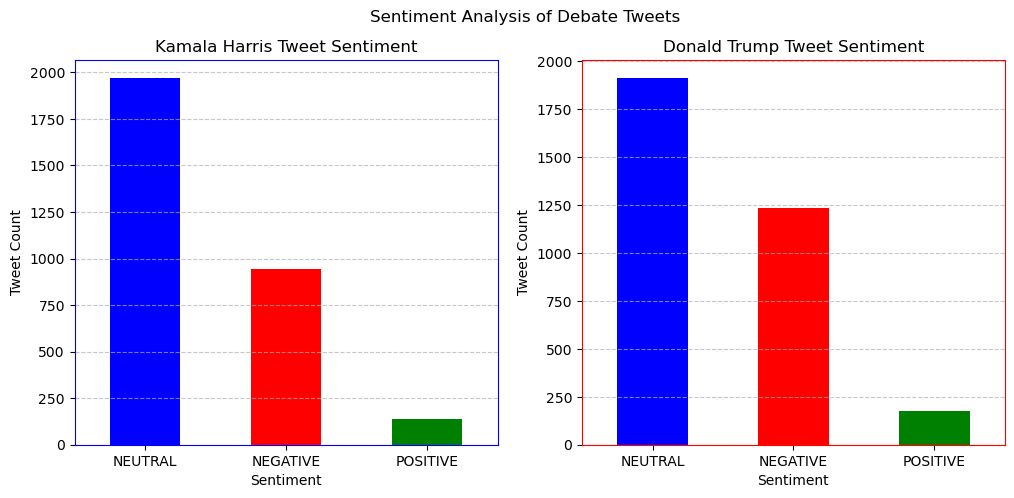

In [13]:
import matplotlib.pyplot as plt

# Define correct sentiment colors
sentiment_colors = {"POSITIVE": "green", "NEUTRAL": "blue", "NEGATIVE": "red"}

# Count sentiment labels
harris_sentiment_counts = harris_df['Sentiment'].value_counts()
trump_sentiment_counts = trump_df['Sentiment'].value_counts()

# Create figure
plt.figure(figsize=(12, 5))

# Harris Sentiment Plot (Blue Theme for Kamala Harris)
plt.subplot(1, 2, 1)
harris_sentiment_counts.plot(kind='bar', title='Kamala Harris Tweet Sentiment', 
                             color=[sentiment_colors[label] for label in harris_sentiment_counts.index])
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_color('blue')
plt.gca().spines['right'].set_color('blue')
plt.gca().spines['bottom'].set_color('blue')
plt.gca().spines['left'].set_color('blue')

# Trump Sentiment Plot (Red Theme for Donald Trump)
plt.subplot(1, 2, 2)
trump_sentiment_counts.plot(kind='bar', title='Donald Trump Tweet Sentiment', 
                            color=[sentiment_colors[label] for label in trump_sentiment_counts.index])
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_color('red')
plt.gca().spines['right'].set_color('red')
plt.gca().spines['bottom'].set_color('red')
plt.gca().spines['left'].set_color('red')

# Set overall title
plt.suptitle("Sentiment Analysis of Debate Tweets")

# Show the plots
plt.show()